1) Бюджет и прибыль по годам
2) Топ прибыльных годов
3) Топ неприбыльных годов
3) Какие фильмы самые прибыльные 
5) Какие фильмы самые популярные
6) Какой фильмы самый высокооцененный
8) У каких фильмов больше всего оценок
9) Топ актеров по количеству фильмов в их карьере
10) Какие общие признаки у самых прибыльных фильмов

# Импорт

In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 3)

# Чтение датасета

In [2]:
original_df = pd.read_csv('dataset/tmdb_movies_data.csv', on_bad_lines='skip')
original_df

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.3,2015,1.747999e+08,1.385749e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10861,21,tt0060371,0.080598,0,0,The Endless Summer,Michael Hynson|Robert August|Lord 'Tally Ho' B...,NaN,Bruce Brown,NaN,...,"The Endless Summer, by Bruce Brown, is one of ...",95,Documentary,Bruce Brown Films,6/15/1966,11,7.4,1966,0.000000e+00,0.000000e+00
10862,20379,tt0060472,0.065543,0,0,Grand Prix,James Garner|Eva Marie Saint|Yves Montand|Tosh...,NaN,John Frankenheimer,Cinerama sweeps YOU into a drama of speed and ...,...,Grand Prix driver Pete Aron is fired by his te...,176,Action|Adventure|Drama,Cherokee Productions|Joel Productions|Douglas ...,12/21/1966,20,5.7,1966,0.000000e+00,0.000000e+00
10863,39768,tt0060161,0.065141,0,0,Beregis Avtomobilya,Innokentiy Smoktunovskiy|Oleg Efremov|Georgi Z...,NaN,Eldar Ryazanov,NaN,...,An insurance agent who moonlights as a carthie...,94,Mystery|Comedy,Mosfilm,1/1/1966,11,6.5,1966,0.000000e+00,0.000000e+00
10864,21449,tt0061177,0.064317,0,0,"What's Up, Tiger Lily?",Tatsuya Mihashi|Akiko Wakabayashi|Mie Hama|Joh...,NaN,Woody Allen,WOODY ALLEN STRIKES BACK!,...,"In comic Woody Allen's film debut, he took the...",80,Action|Comedy,Benedict Pictures Corp.,11/2/1966,22,5.4,1966,0.000000e+00,0.000000e+00


# Очистка от мусорных строк

#### Удаление дубликатов

In [3]:
original_df.duplicated().sum()

1

In [4]:
original_df.drop_duplicates(inplace=True)
original_df.duplicated().sum()

0

In [5]:
original_df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7929
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

#### Удаляем пустые строки у тех столбцов, которые будем использовать

In [6]:
original_df.dropna(subset=['cast', 'director', 'production_companies', 'genres'], inplace=True)

In [7]:
original_df.isnull().sum()

id                         0
imdb_id                    2
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                       0
homepage                7135
director                   0
tagline                 2137
keywords                1106
overview                   0
runtime                    0
genres                     0
production_companies       0
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

# Получение нужных столбцов из исходного DataFrame

In [8]:
desired_columns_df: pd.DataFrame = original_df.drop(columns=['imdb_id', 'homepage', 'budget_adj', 'revenue_adj',
                                                             'tagline', 'keywords','overview', 'release_date'])
# отсеивание короткометражных фильмов с маленьким бюджетом
desired_columns_df = desired_columns_df.query('revenue > 0 and budget > 0 and runtime > 60')
desired_columns_df

,id,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,vote_count,vote_average,release_year
0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,5562,6.5,2015
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,6185,7.1,2015
2,262500,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2480,6.3,2015
3,140607,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,5292,7.5,2015
4,168259,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2947,7.3,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10822,396,0.670274,7500000,33736689,Who's Afraid of Virginia Woolf?,Elizabeth Taylor|Richard Burton|George Segal|S...,Mike Nichols,131,Drama,Chenault Productions,74,7.5,1966
10828,5780,0.402730,3000000,13000000,Torn Curtain,Paul Newman|Julie Andrews|Lila Kedrova|HansjÃ¶...,Alfred Hitchcock,128,Mystery|Thriller,Universal Pictures,46,6.3,1966
10829,6644,0.395668,4653000,6000000,El Dorado,John Wayne|Robert Mitchum|James Caan|Charlene ...,Howard Hawks,120,Action|Western,Paramount Pictures|Laurel Productions,36,6.9,1966
10835,5923,0.299911,12000000,20000000,The Sand Pebbles,Steve McQueen|Richard Attenborough|Richard Cre...,Robert Wise,182,Action|Adventure|Drama|War|Romance,Twentieth Century Fox Film Corporation|Solar P...,28,7.0,1966


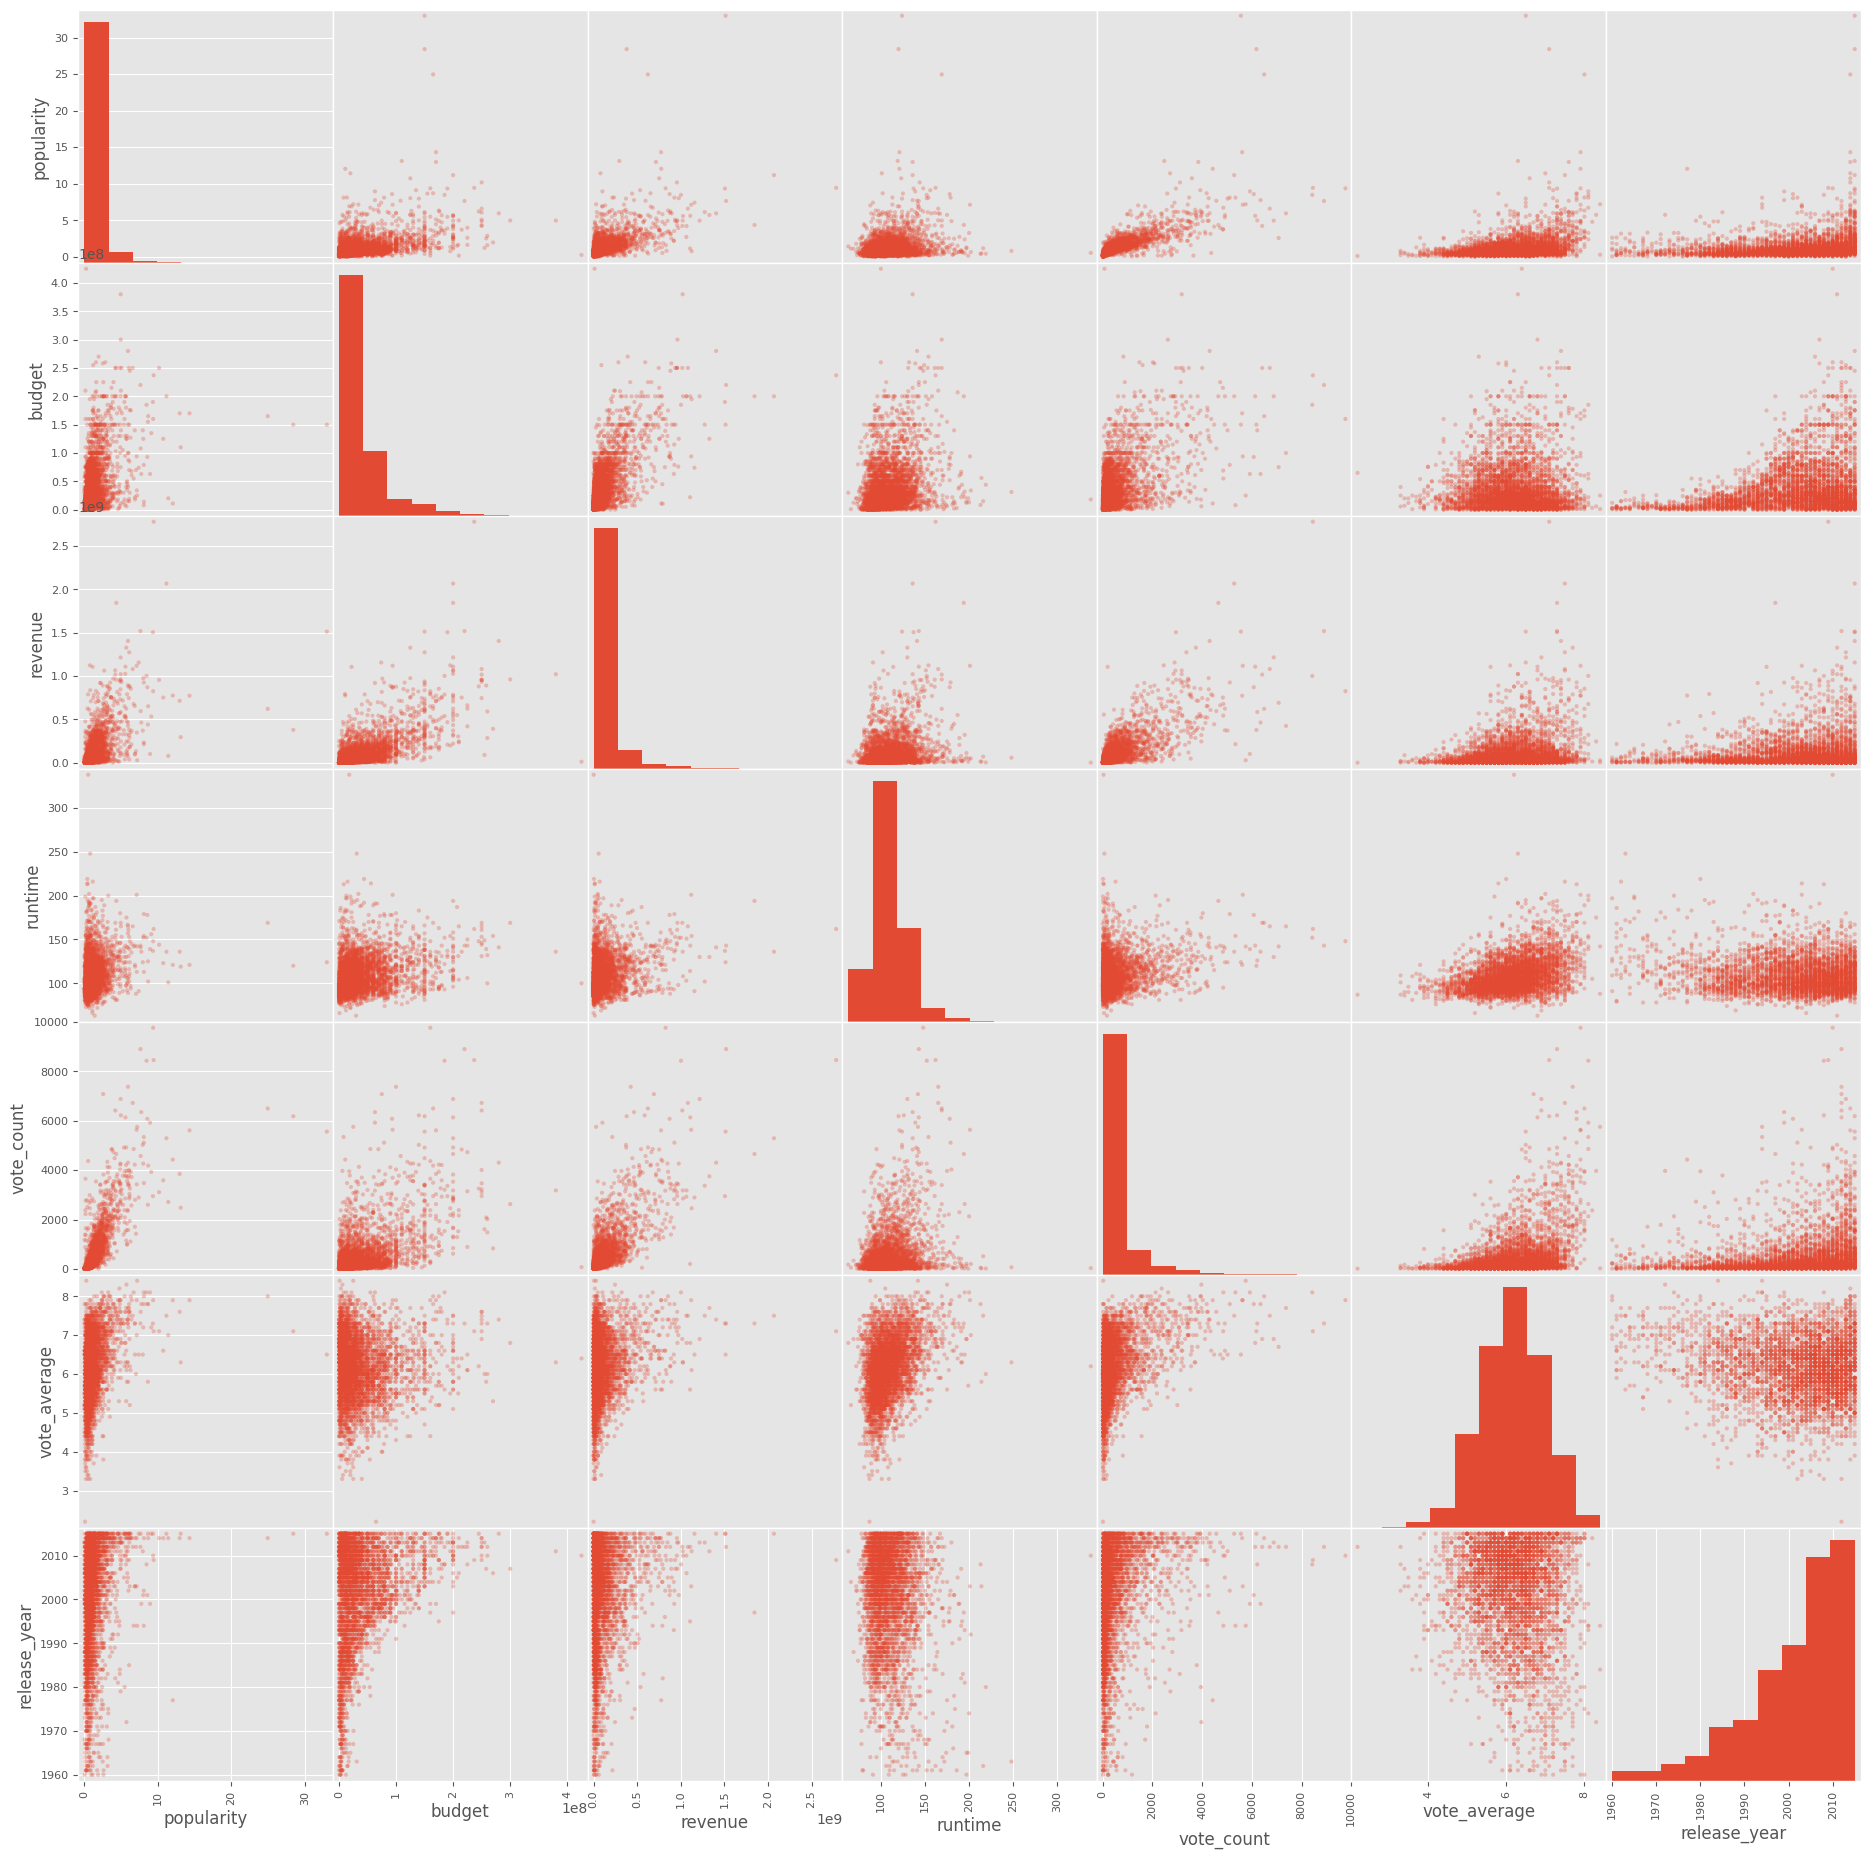

In [9]:
pd.plotting.scatter_matrix(desired_columns_df.drop(columns=['id']), alpha=0.3, figsize=(23,23), grid=True)
plt.show()

In [10]:
desired_columns_df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year
count,3803.000000,3803.000000,3.803000e+03,3.803000e+03,3803.000000,3803.000000,3803.000000,3803.000000
mean,40050.983697,1.204207,3.762699e+07,1.090252e+08,109.397844,534.412306,6.170076,2001.233500
std,67601.798646,1.480837,4.232480e+07,1.773297e+08,19.745561,883.920541,0.792328,11.328701
min,5.000000,0.010335,1.000000e+00,2.000000e+00,63.000000,10.000000,2.200000,1960.000000
25%,5924.500000,0.470695,1.000000e+07,1.434513e+07,96.000000,74.000000,5.700000,1995.000000
50%,11252.000000,0.811236,2.500000e+07,4.622119e+07,106.000000,209.000000,6.200000,2004.000000
75%,38662.000000,1.387598,5.000000e+07,1.261432e+08,119.000000,584.500000,6.700000,2010.000000
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,338.000000,9767.000000,8.400000,2015.000000


In [11]:
desired_columns_df.select_dtypes(include='number').median()

id              1.125200e+04
popularity      8.112360e-01
budget          2.500000e+07
revenue         4.622119e+07
runtime         1.060000e+02
vote_count      2.090000e+02
vote_average    6.200000e+00
release_year    2.004000e+03
dtype: float64

## Векторизация
Приведение строк, разделенных символом "|", к бинарным векторам с помощью CountVectorizer из библиотеки scikit-learn

#### 1. Векторизация режиссеров

In [12]:
def tokenize(text):
    """Функция токенизации"""
    return text.split('|')

directors_vectorizer = CountVectorizer(tokenizer=tokenize)
directors_data = pd.DataFrame(directors_vectorizer.fit_transform(desired_columns_df['director']).toarray(), 
                              index=desired_columns_df.id, columns=directors_vectorizer.get_feature_names_out())

directors_data.head(2)

C:\Users\Тимур\Desktop\movie_practice\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,frã©dã©ric jardin,aaron blaise,aaron seltzer,abbas tyrewala,abe sylvia,abel ferrara,adam green,adam marcus,adam mckay,adam rifkin,...,xavier dolan,xavier gens,xavier palud,yorgos lanthimos,yvan attal,zach braff,zack snyder,zal batmanglij,zillah bowes,ã‰mile gaudreault
id,,,,,,,,,,,,,,,,,,,,,
135397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2. Векторизация актеров

In [13]:
cast_vectorizer = CountVectorizer(tokenizer=tokenize)
cast_data = pd.DataFrame(cast_vectorizer.fit_transform(desired_columns_df['cast']).toarray(), index=desired_columns_df.id, 
                     columns=cast_vectorizer.get_feature_names_out())
cast_data.head(2)

C:\Users\Тимур\Desktop\movie_practice\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,50 cent,a martinez,a. michael baldwin,a.j. cook,aaliyah,aamir khan,aaran thomas,aaron abrams,aaron burns,aaron eckhart,...,zoie palmer,zooey deschanel,zoã« bell,zoã« borde,zoã« kravitz,zuleikha robinson,à¸ªà¸£à¸žà¸‡à¸©à¹œ à¸šà¸²à¸•à¸£à¸µ,ãngela molina,ã“lafur darri ã“lafsson,äá»— thá»‹ háº£i yáº¿n
id,,,,,,,,,,,,,,,,,,,,,
135397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 3. Векторизация продакшн компаний

In [14]:
prod_vectorizer = CountVectorizer(tokenizer=tokenize)
prod_data = pd.DataFrame(prod_vectorizer.fit_transform(desired_columns_df['production_companies']).toarray(), 
                         index=desired_columns_df.id, columns=prod_vectorizer.get_feature_names_out())
prod_data.head(2)

C:\Users\Тимур\Desktop\movie_practice\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,"""dia"" productions gmbh & co. kg",1019 entertainment,10th hole productions,11:11 mediaworks,120db films,1492 pictures,1818,1821 pictures,1984 private defense contractors,2 bridges productions,...,zininsa film production,zippcast films,zoetrope argentina,zoetrope studios,zohar international,zone productions,zucker brothers productions,zucker/netter productions,zupnik cinema group ii,zweites deutsches fernsehen (zdf)
id,,,,,,,,,,,,,,,,,,,,,
135397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 4. Векторизация жанров

In [15]:
genre_vectorizer = CountVectorizer(tokenizer=tokenize)
genre_data = pd.DataFrame(genre_vectorizer.fit_transform(desired_columns_df['genres']).toarray(), index=desired_columns_df.id, 
                     columns=genre_vectorizer.get_feature_names_out())
genre_data.head(2)

C:\Users\Тимур\Desktop\movie_practice\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
id,,,,,,,,,,,,,,,,,,,,
135397,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
76341,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


# Способы разделения данных и визуализация

### 1. По количеству фильмов у режиссеров

In [56]:
directors_data_sum = directors_data.sum().sort_values(ascending=False)
directors_data_sum

steven spielberg       28
clint eastwood         24
ridley scott           21
woody allen            18
martin scorsese        17
                       ..
jeff newitt             1
jeff baena              1
jeb stuart              1
jean-paul rappeneau     1
ã‰mile gaudreault       1
Length: 1751, dtype: int64

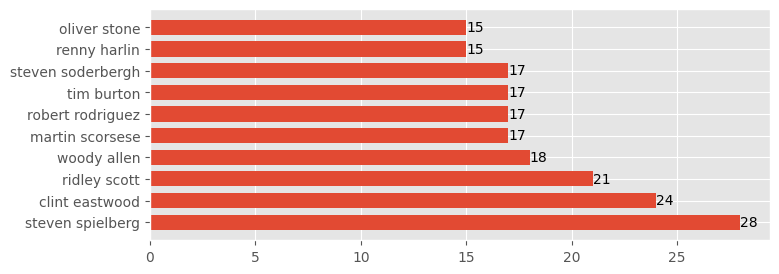

In [63]:
movie_by_director_bars = plt.barh(directors_data_sum[:10].index, 
                                  directors_data_sum[:10].values, 0.7)

plt.bar_label(movie_by_director_bars)
plt.show()

### 2. По экономической целесообразности

In [33]:
revenue_budget_by_year = desired_columns_df.groupby('release_year', as_index=False).agg({'revenue': 'sum', 'budget': 'sum'})    
revenue_budget_by_year_sorted = revenue_budget_by_year.sort_values('revenue', ascending=False)

revenue_budget_by_year_sorted.head(2)

,release_year,revenue,budget
55,2015,26202922801,7170777528
53,2013,24349476491,8562922778


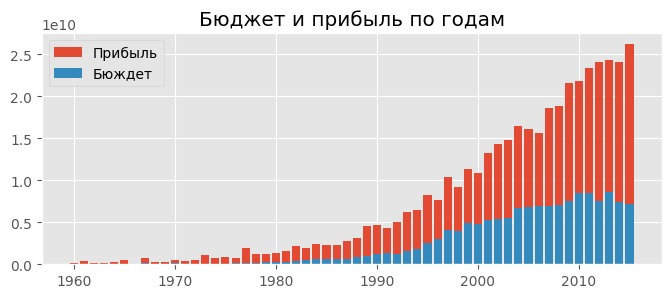

In [34]:
plt.title('Бюджет и прибыль по годам')
plt.bar(revenue_budget_by_year_sorted['release_year'], revenue_budget_by_year_sorted['revenue'], label='Прибыль')
plt.bar(revenue_budget_by_year_sorted['release_year'], revenue_budget_by_year_sorted['budget'], label='Бюждет')
plt.legend()
plt.show()

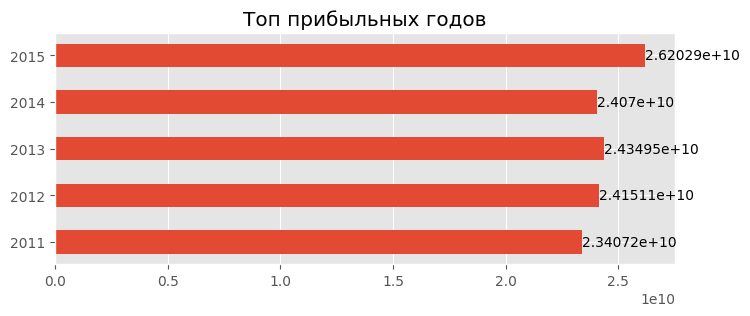

In [36]:
revenue_by_year_max_bars = plt.barh(revenue_budget_by_year_max[:5]['release_year'], 
                                    revenue_budget_by_year_max[:5]['revenue'], 0.5)

plt.bar_label(revenue_by_year_max_bars)
plt.title('Топ прибыльных годов')
plt.show()

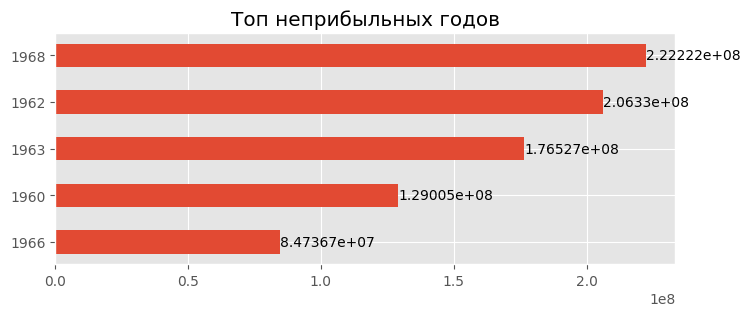

In [25]:
years_ticks = [str(year) for year in revenue_by_year_min['release_year']]

revenue_by_year_min_bars = plt.barh(years_ticks, revenue_by_year_min['revenue'], 0.5)
plt.bar_label(revenue_by_year_min_bars)
plt.title('Топ неприбыльных годов')
plt.show()

In [26]:
revenue_by_title_max = desired_columns_df.sort_values('revenue', ascending=False)[:10][['original_title', 'budget', 'revenue']][:10]
revenue_by_title_max

,original_title,budget,revenue
1386,Avatar,237000000,2781505847
3,Star Wars: The Force Awakens,200000000,2068178225
5231,Titanic,200000000,1845034188
4361,The Avengers,220000000,1519557910
0,Jurassic World,150000000,1513528810
4,Furious 7,190000000,1506249360
14,Avengers: Age of Ultron,280000000,1405035767
3374,Harry Potter and the Deathly Hallows: Part 2,125000000,1327817822
5422,Frozen,150000000,1274219009
5425,Iron Man 3,200000000,1215439994


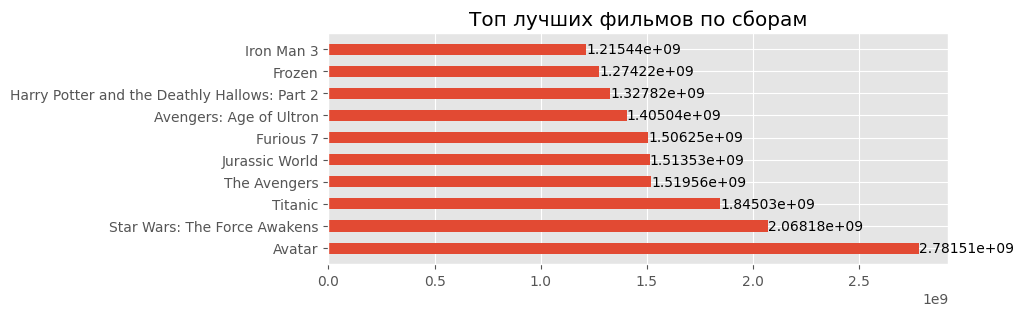

In [27]:
revenue_by_title_max_bars = plt.barh(revenue_by_title_max['original_title'], revenue_by_title_max['revenue'], 0.5)

plt.bar_label(revenue_by_title_max_bars)
plt.title('Топ лучших фильмов по сборам')
plt.show()

### 3. По популярности фильмов

In [40]:
popularity_title_max = desired_columns_df.sort_values('popularity', ascending=False)[:10][['original_title', 'popularity']]
popularity_title_max.tail(3)

,original_title,popularity
632,John Wick,11.422751
3,Star Wars: The Force Awakens,11.173104
633,The Hunger Games: Mockingjay - Part 1,10.739009


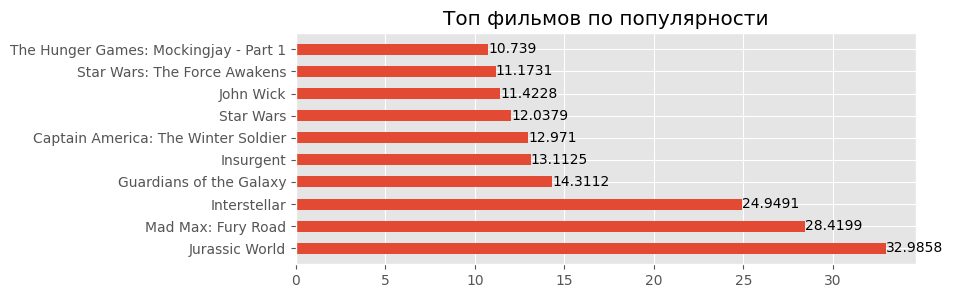

In [29]:
popularity_title_max_bars = plt.barh(popularity_title_max[:10]['original_title'], popularity_title_max[:10]['popularity'], 0.5)

plt.bar_label(popularity_title_max_bars)
plt.title('Топ фильмов по популярности')
plt.show()

### 4. Количество фильмов в жанрах

In [64]:
genre_data_sum = genre_data.sum().sort_values(ascending=False)
genre_data_sum

drama              1729
comedy             1335
thriller           1194
action             1076
adventure           743
romance             658
crime               649
science fiction     516
horror              459
family              416
fantasy             395
mystery             343
animation           197
music               131
history             128
war                 119
western              52
documentary          26
foreign               9
tv movie              1
dtype: int64

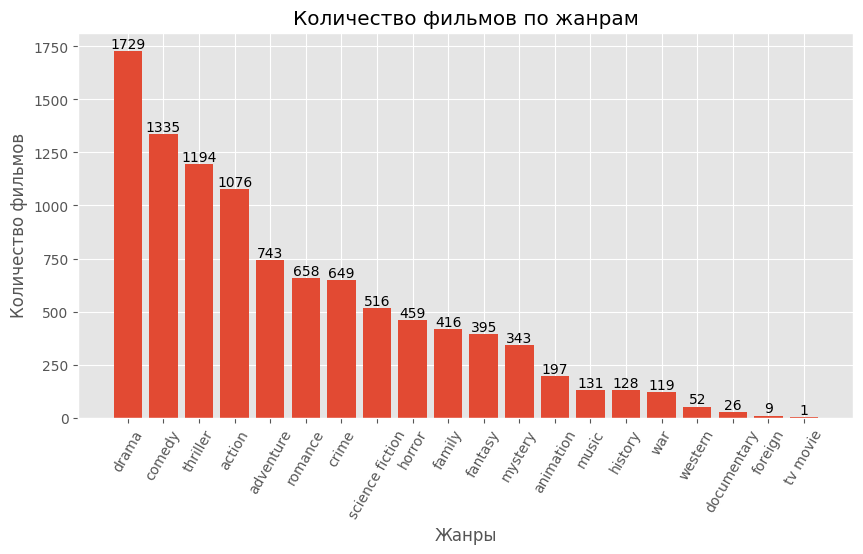

In [62]:
plt.figure(figsize=(10, 5))
count_movie_in_genre_bars = plt.bar(genre_data_sum.index, genre_data_sum.values) 
plt.bar_label(count_movie_in_genre_bars)
plt.title('Количество фильмов по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=60)
plt.show()

### 5. Популярность жанров

In [77]:
genre_popularity_df = desired_columns_df[['popularity']].merge(genre_data, on=desired_columns_df.index)
genre_popularity_df.pop('key_0')
genre_popularity_df.head(3)

,popularity,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,...,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
0,32.985763,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,28.419936,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,13.112507,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [82]:
popularity_by_genre = (genre_popularity_df[genre_popularity_df.columns[1:]].transpose() * 
                       genre_popularity_df['popularity']).transpose()
popularity_by_genre.head(2)

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
0,32.985763,32.985763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.985763,32.985763,0.0,0.0,0.0
1,28.419936,28.419936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.419936,28.419936,0.0,0.0,0.0


In [86]:
popularity_by_genre_sum = popularity_by_genre.sum().sort_values(ascending=False)
popularity_by_genre_sum

drama              1752.039257
action             1698.270756
thriller           1513.366992
adventure          1397.414053
comedy             1368.546314
science fiction     971.432840
crime               731.325436
fantasy             694.597180
romance             635.125576
family              617.444171
horror              393.664273
mystery             392.843701
animation           342.349669
war                 148.289378
history             124.668327
music               121.009314
western              58.980777
documentary           9.192380
foreign               1.727512
tv movie              0.273628
dtype: float64

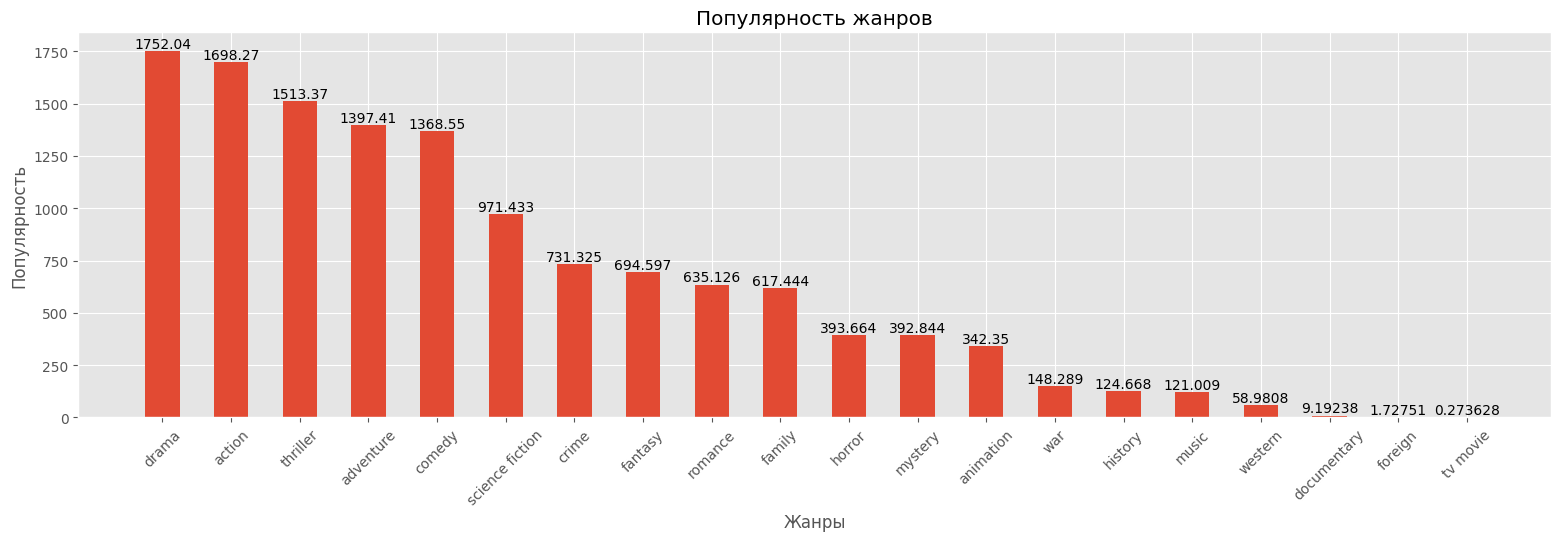

In [96]:
plt.figure(figsize=(19, 5))

popularity_by_genre_bars = plt.bar(popularity_by_genre_sum.index, popularity_by_genre_sum.values, 0.5)

plt.bar_label(popularity_by_genre_bars)
plt.xlabel('Жанры')
plt.ylabel('Популярность')
plt.title('Популярность жанров')
plt.xticks(rotation=45)
plt.show()

### 6. В скольких фильмах снимались актеры

In [58]:
cast_data_sum = cast_data.sum().sort_values(ascending=False)
cast_data_sum

robert de niro            52
bruce willis              46
samuel l. jackson         44
nicolas cage              43
matt damon                36
                          ..
jason bonham               1
jason behr                 1
jason barry                1
jason aldean               1
äá»— thá»‹ háº£i yáº¿n     1
Length: 6740, dtype: int64

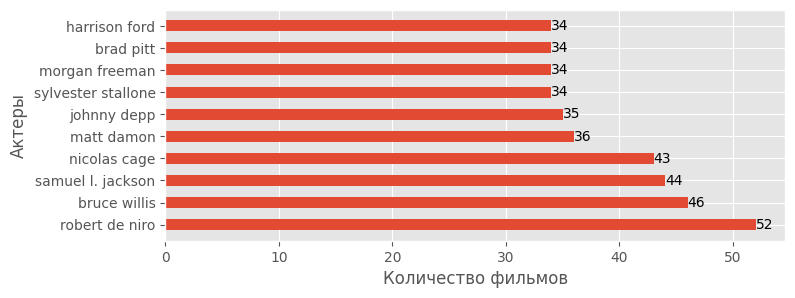

In [98]:
actors_movies_bars = plt.barh(cast_data_sum[:10].index, cast_data_sum[:10].values, 0.5)

plt.bar_label(actors_movies_bars)
plt.xlabel('Количество фильмов')
plt.ylabel('Актеры')
plt.show()

# Корреляция бюджета и сборов

In [114]:
budget_revenue_corr = desired_columns_df[['budget', 'revenue']].corr()
budget_revenue_corr.style.background_gradient(cmap='RdYlGn')

,budget,revenue
budget,1.000000,0.686996
revenue,0.686996,1.000000


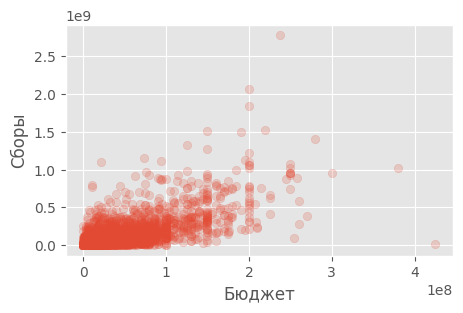

In [97]:
plt.figure(figsize=(5, 3))
plt.scatter(desired_columns_df['budget'], desired_columns_df['revenue'], alpha=0.2)
plt.xlabel('Бюджет')
plt.ylabel('Cборы')
plt.show()

# Простая линейная регрессия
# $$ Y=a+b*x $$ 
### где \\(a\\)- сдвиг линии по оси \\(y\\), \\(b\\)- наклон линии.

In [128]:
X = np.array(desired_columns_df['budget']).reshape(-1, 1)
y = np.array(desired_columns_df['revenue']).reshape(-1, 1)
linear_reg_revenue = LinearRegression().fit(X, y)

In [130]:
linear_reg_revenue.coef_

array([[2.87833214]])

#### Линейная регрессия показала плохой результат

In [131]:
linear_reg_revenue.score(X, y)

0.47196401971292623

## Визуализация линейной регрессии

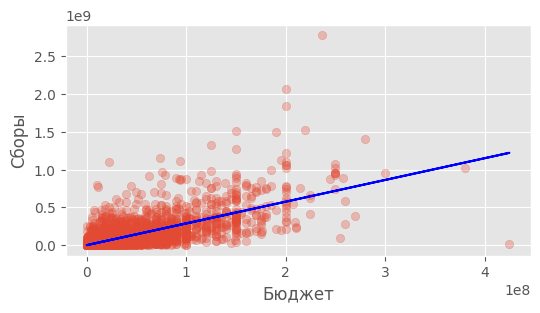

In [132]:
x, y = desired_columns_df['budget'], desired_columns_df['revenue']
plt.figure(figsize=(6, 3))
plt.scatter(x, y, alpha=0.3)
plt.plot(x, linear_reg_revenue.predict(X), color='blue')
plt.xlabel('Бюджет')
plt.ylabel('Cборы')
plt.show()

# Множественная линейная регрессия
# $$ Y = a + b1*x1 + b2*x2 + ... + bp*xp $$

In [133]:
indexes = [0, 1, 2]
df_for_multiple_reg = desired_columns_df.iloc[:, indexes]
df_for_multiple_reg.head(2)

,id,popularity,budget
0,135397,32.985763,150000000
1,76341,28.419936,150000000


In [104]:
# Добавить режиссеров в датафрейм
prepared_df_for_multiple_reg = df_for_multiple_reg.merge(directors_data, on=df_for_multiple_reg.index)
prepared_df_for_multiple_reg.pop('key_0')
# Добавить актеров в датафрейм
# prepared_df_for_multiple_reg = prepared_df_for_multiple_reg.merge(cast_data, on=df_for_multiple_reg.index)
# prepared_df_for_multiple_reg.pop('key_0')
# Добавить продакшн-компании в датафрейм
# prepared_df_for_multiple_reg = prepared_df_for_multiple_reg.merge(prod_data, on=df_for_multiple_reg.index)
# prepared_df_for_multiple_reg.pop('key_0')
# Добавить жанры в датафрейм
# prepared_df_for_multiple_reg = prepared_df_for_multiple_reg.merge(genre_data, on=df_for_multiple_reg.index)
# prepared_df_for_multiple_reg.pop('key_0')
prepared_df_for_multiple_reg.head(5)

,id,popularity,budget,frã©dã©ric jardin,aaron blaise,aaron seltzer,abbas tyrewala,abe sylvia,abel ferrara,adam green,...,xavier dolan,xavier gens,xavier palud,yorgos lanthimos,yvan attal,zach braff,zack snyder,zal batmanglij,zillah bowes,ã‰mile gaudreault
0,135397,32.985763,150000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,76341,28.419936,150000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,262500,13.112507,110000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,140607,11.173104,200000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,168259,9.335014,190000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
revenue = desired_columns_df['revenue']
features = prepared_df_for_multiple_reg.drop(columns=['id'])
X_train, X_test, y_train, y_test = train_test_split(features, revenue, test_size=0.2, random_state=20)

In [134]:
multiple_reg = LinearRegression().fit(X_train, y_train)

In [135]:
print(multiple_reg.score(X_train, y_train))
print(multiple_reg.score(X_test, y_test))

0.7892406909031632
0.49039117843051505


In [108]:
multiple_reg.coef_

array([ 3.79817112e+07,  1.78964245e+00, -2.95368597e+06, ...,
       -4.03762026e+06,  2.55489443e+07,  2.72833411e+06])

# Метод случайного леса

In [26]:
random_forest = RandomForestRegressor(n_estimators=250).fit(X_train, y_train)

#### Результат намного лучше, чем у линейной регрессии

In [28]:
print(random_forest.score(X_train, y_train))
print(random_forest.score(X_test, y_test))

0.951623318595013
0.6107241411858779


# Градиентный бустинг

In [110]:
gradient_boost = GradientBoostingRegressor().fit(X_train, y_train)

In [136]:
print(gradient_boost.score(X_train, y_train))
print(gradient_boost.score(X_test, y_test))

0.792355953913786
0.6753419290862575


#### Лучший результат из всех примененных моделей